# MNISTデータを簡単なCNNモデルで学習し、ClassActivationMapを表示する

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import np_utils

from dataloader import Dataloader
from solver import Solver

Using TensorFlow backend.


In [2]:
# tensorflow GPU用の設定
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# データのダウンロード

In [4]:
dataloader_ins = Dataloader()
dataloader_ins.get_mnist_data(resize_mode=False, resize_shape=None, cvtColor_mode = False)

print("x_train shape : {}".format(dataloader_ins.x_train.shape))
print("y_train shape : {}".format(dataloader_ins.y_train.shape))

x_train shape : (500, 28, 28, 1)
y_train shape : (500, 10)


Text(0.5, 1.0, 'ans=1')

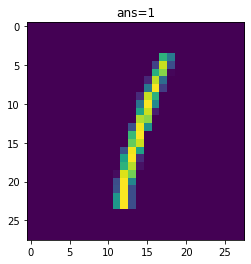

In [5]:
# 図示
i = np.random.randint(len(dataloader_ins.x_train))

image = dataloader_ins.x_train[i, :, :, 0]
ans = dataloader_ins.y_train[i].argmax()
plt.imshow(image)
plt.title('ans=' + str(ans))

# モデルの定義

In [6]:
from keras.layers import Input, ZeroPadding2D, Conv2D, GlobalAveragePooling2D, Dense, Dropout
from keras import Model

In [7]:
# getTrainModel関数で keras.model を返すクラスを定義

class Usermodel_MNIST_easyCNN:
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def getTrainModel(self):
        # モデル定義
        inputs = Input(shape=input_shape)
        x = Conv2D(32, (5, 5), strides=(2, 2), padding='same', activation='relu', input_shape=input_shape)(inputs)
        x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
        x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', name='feature_map')(x)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.5)(x)
        outputs = Dense(10, activation='softmax', name='dense')(x)
        # モデル作成
        model = Model(inputs=inputs, outputs=outputs)
        return model

In [8]:
# モデル用クラスのインスタンス生成
input_shape = dataloader_ins.x_train[0].shape
usermodel_ins = Usermodel_MNIST_easyCNN(input_shape)

# 学習

In [11]:
solver_ins = Solver(dataloader_ins, usermodel_ins, n_epochs=10)

In [12]:
model = solver_ins.get_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
solver_ins.train(model, batch_size=10)

x_train shape (500, 28, 28, 1)
y_train shape (500, 10)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 500 samples, validate on 500 samples



Epoch 1/10
500/500 [==============================] - 4s 8ms/step - loss: 0.3252 - categorical_accuracy: 0.1040 - val_loss: 0.3238 - val_categorical_accuracy: 0.1860

Epoch 00001: val_loss improved from inf to 0.32377, saving model to final_weights_step.hdf5

Epoch 2/10
500/500 [==============================] - 1s 2ms/step - loss: 0.3225 - categorical_accuracy: 0.1240 - val_loss: 0.3175 - val_categorical_accuracy: 0.1240

Epoch 00002: val_loss improved from 0.32377 to 0.31749, saving model to final_weights_step.hdf5
Epoch 3/10
500/500 [==============================] - 1s 2ms/step - loss: 0.3086 - categorical_accuracy: 0.2360 - val_loss: 0.3005 - val_categorical_accuracy: 0.2920

Epoch 00003: val_loss improved from 0.31749 to 0.30054, saving model to final_weights_step.hdf5
Epoch 4/10
500/

# 結果

Text(0.5, 1.0, 'pred=5, ans=5')

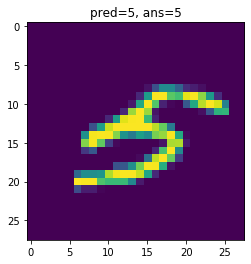

In [15]:
# テスト画像の表示
i = np.random.randint(len(dataloader_ins.x_test))
pred = model.predict(dataloader_ins.x_test[i:i+1])
pred_num = pred.argmax()

image = dataloader_ins.x_test[i, :, :, 0]
ans = dataloader_ins.y_test[i].argmax()
plt.imshow(image)
plt.title('pred=' + str(pred_num) + ', ans=' + str(ans))

# CAM

In [16]:
from class_activation_map import ClassActivationMap

In [21]:
# ClassActivationMap計算用クラスの作成
cam = ClassActivationMap(model, layer_GAP=-3, layer_dense=-1)

In [22]:
# CAMを計算したい画像
images = dataloader_ins.x_test[[0]]
labels = dataloader_ins.y_test[[0]]
images.shape

(1, 28, 28, 1)

In [23]:
# ClassActivationMapを計算
cam_images = cam.get_class_activation_map(images)
cam_images.shape

(1, 14, 14, 10)

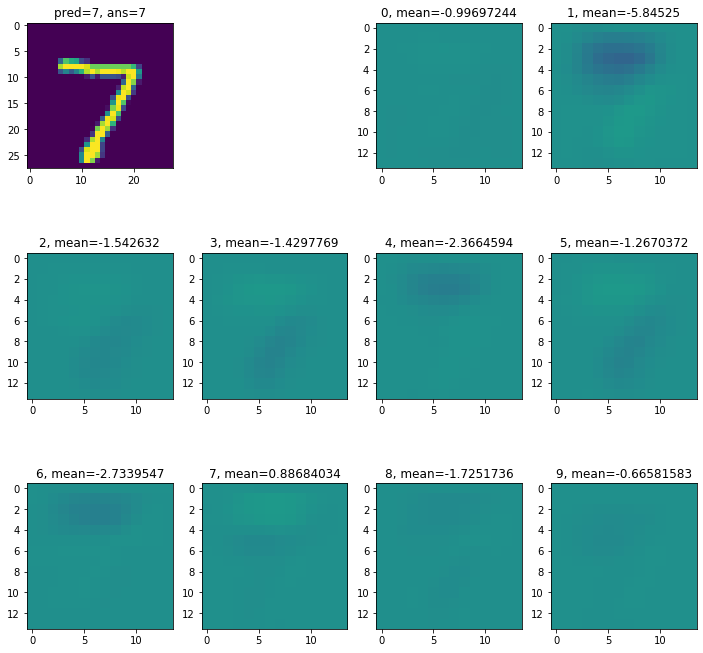

In [24]:
# 図示する画像を一枚だけ選ぶ
i = 0
image = images[i]
label = labels[i]
cam_image = cam_images[i]

# 予測結果と答えを計算
pred = model.predict(image[np.newaxis, :, :, :]).argmax()  # 予測結果
ans = labels[i].argmax()  # 答え

### 図示 ###
plt.figure(figsize=(12, 12))
# 元画像
plt.subplot(341)
plt.imshow(image[:, :, 0])
plt.title('pred={0}, ans={1}'.format(pred, ans))
# CAM
for j in range(10):
    cam_class = cam_image[:, :, j]  # あるクラスのCAMを取得
    plt.subplot(3, 4, j+3)
    plt.imshow(cam_class, vmin=-200, vmax=200)
    plt.title(str(j) + ', mean=' + str(cam_class.mean()))  # あるクラスのCAMの平均